# Task 1 - Movie Genre Prediction

In [1]:
!pip install kaggle

### Downloading and Extracting the dataset

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#downloading the dataset from kaggle via kaggle API

!kaggle datasets download -d hijest/genre-classification-dataset-imdb

Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
License(s): other
genre-classification-dataset-imdb.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#Extracting the compressed dataset

from zipfile import ZipFile

dataset = '/content/genre-classification-dataset-imdb.zip'

with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('The data is extracted successfully...')

The data is extracted successfully...


### Importing the Dependencies

In [7]:
#importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


### Loading train, test and test_sol data

In [9]:
#training data path
train_data_path = "/content/Genre Classification Dataset/train_data.txt"
test_data_path = "/content/Genre Classification Dataset/test_data.txt"
test_sol_path = "/content/Genre Classification Dataset/test_data_solution.txt"

#Converting the dataset into csv file
train_data = pd.read_csv(train_data_path, sep = " ::: ", names = ['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine = 'python')
test_data = pd.read_csv(test_data_path, sep = " ::: ", names = ['ID', 'TITLE', 'DESCRIPTION'], engine = 'python')
test_sol = pd.read_csv(test_sol_path, sep = " ::: ", names = ['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine = 'python')

In [10]:
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [11]:
test_data.head()

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),Before he was known internationally as a marti...


In [12]:
test_sol.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...


In [13]:
#Checking the shape of the dataset
train_data.shape

(54214, 4)

In [14]:
#describing the dataset
train_data[['TITLE', 'GENRE', 'DESCRIPTION']].describe()

,TITLE,GENRE,DESCRIPTION
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy o...
freq,1,13613,12


Note: Describing the id column wont be of any use

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


Only ID column has 'int' datatype

In [16]:
#Checking for null values throughout the dataset
train_data.isnull().sum()

,0
ID,0
TITLE,0
GENRE,0
DESCRIPTION,0


Great! No null values

### EDA and Data Vizualization

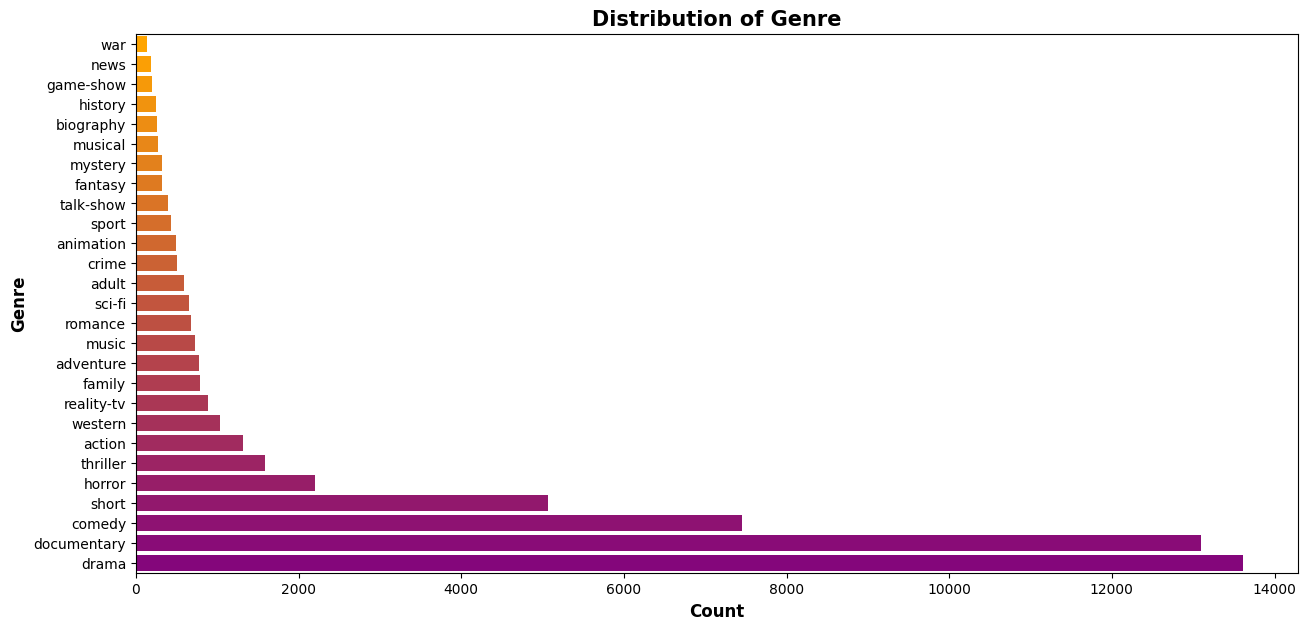

In [17]:
#Describing the figure size
plt.figure(figsize = (15, 7))

#Creating the countplot
sns.countplot(data = train_data, y = 'GENRE', hue = None,order = train_data['GENRE'].value_counts().index[::-1])

#Access the matplotlib axes
ax = plt.gca()

#create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("", ["orange", "purple"])

#Iterate over the bars and set colors
for i, bar in enumerate(ax.patches):
    color = cmap(i/len(ax.patches))
    bar.set_facecolor(color)

#set title for the plot
plt.title('Distribution of Genre', fontsize = 15, fontweight = 'bold')
#set label for x axis
plt.xlabel('Count', fontsize = 12, fontweight = 'bold')
#set label for y axis
plt.ylabel('Genre', fontsize = 12, fontweight = 'bold')
plt.show()

In [18]:
train_data['DESCRIPTION_LENGTH'] = train_data['DESCRIPTION'].str.len()
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,DESCRIPTION_LENGTH
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,545
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,183
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,649
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,1081
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,624


In [19]:
train_data['DESCRIPTION_LENGTH'].describe()

,DESCRIPTION_LENGTH
count,54214.000000
mean,599.452429
std,446.026620
min,41.000000
25%,324.000000
50%,463.000000
75%,712.000000
max,10503.000000


Text(0, 0.5, 'Frequency')

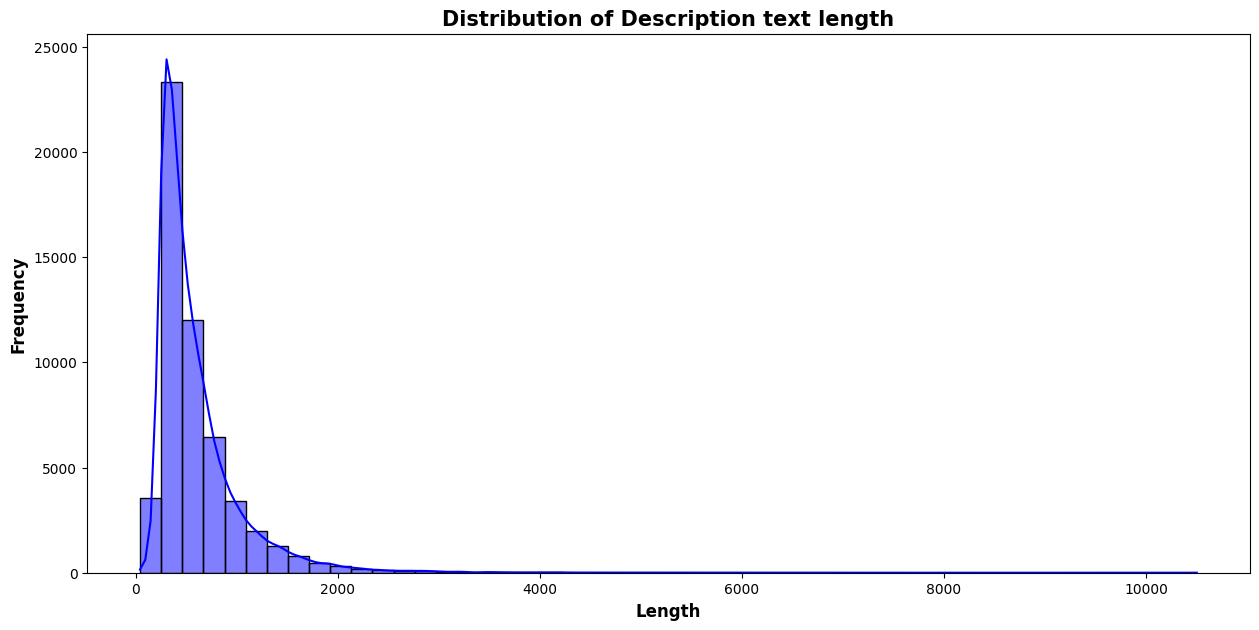

In [20]:
plt.figure(figsize = (15, 7))

#plot histogram
sns.histplot(data = train_data, x = 'DESCRIPTION_LENGTH', kde = True, bins = 50, color = 'blue')

#set title
plt.title('Distribution of Description text length', fontsize = 15, fontweight = 'bold')

#set label for x axis
plt.xlabel('Length', fontsize = 12, fontweight = 'bold')

#set label for y axis
plt.ylabel('Frequency', fontsize = 12, fontweight = 'bold')

Text(0.5, 0, 'Length')

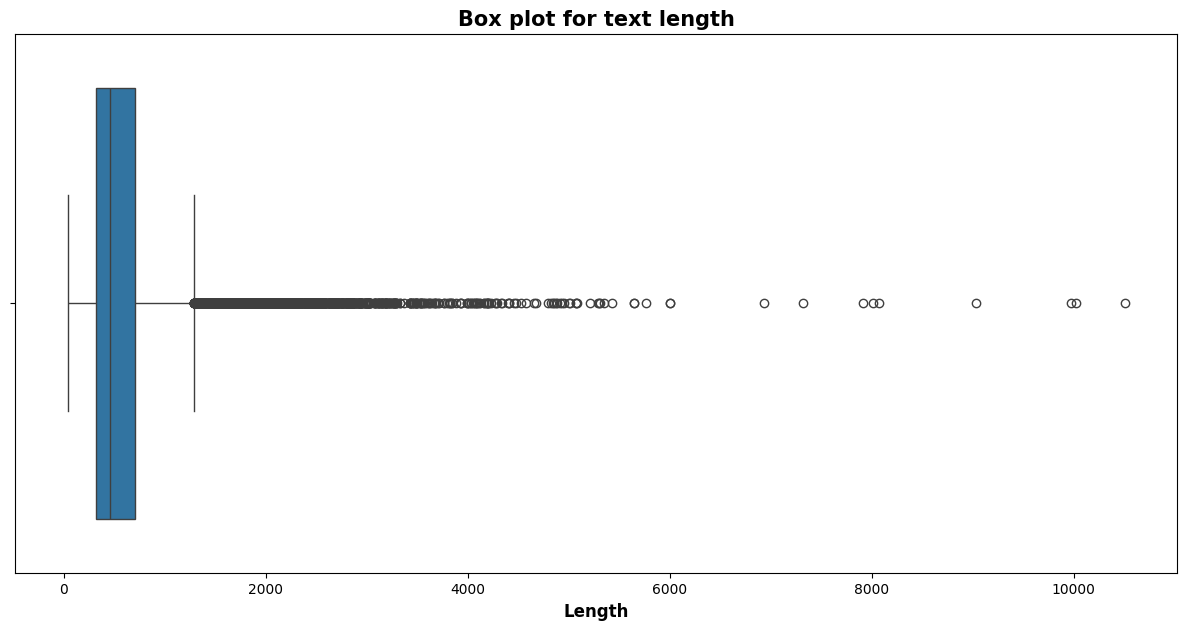

In [21]:
plt.figure(figsize = (15, 7))

#Plot Boxplot
sns.boxplot(x = train_data['DESCRIPTION_LENGTH'])

#set title
plt.title('Box plot for text length', fontsize = 15, fontweight = 'bold')

#set label for x axis
plt.xlabel('Length', fontsize = 12, fontweight = 'bold')

In [22]:
len(train_data[train_data['DESCRIPTION_LENGTH'] > 2000])

863

In [23]:
len(train_data[(train_data['DESCRIPTION_LENGTH'] > 4000) & (train_data['DESCRIPTION_LENGTH'] < 10000)])

67

### Data Cleaning and Preprocessing

In [24]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
stemmer = LancasterStemmer()
stopwords = set(stopwords.words('english'))

In [26]:
print(stopwords)

{'most', "couldn't", 'and', 'any', 'its', 'same', 'by', 'very', "weren't", 're', 'do', 'am', 'haven', 'here', "isn't", 'where', 'her', 'having', "don't", 'will', "mustn't", 'didn', 'i', 'against', 'doesn', 'own', "she's", 'then', 'have', 'doing', 'who', 'at', 'just', 'few', 'other', 'of', 'had', 'about', 'shouldn', 'the', "hasn't", 'out', 'can', 'through', 'from', 'off', 'been', 'ain', 'was', 'm', 'too', 'such', 'because', 'for', 'wouldn', 'what', "doesn't", 's', 'were', 't', "you'll", 'won', 'into', 'hers', 'some', 'an', 'not', 'he', 'yourselves', 'whom', 'o', 'd', 'itself', 'over', 'did', 'yourself', 'why', 'more', "it's", 'hasn', 'there', "you're", 'in', "shan't", 'only', "wasn't", 'again', 'they', 'are', 'it', 'once', 'both', 'y', 'll', 'down', 'isn', 'mightn', 'our', 'ours', 'themselves', "haven't", "shouldn't", "mightn't", 'aren', 'we', "you've", 'me', "needn't", "hadn't", 'between', 'him', 'no', 'weren', 'does', 'she', 'which', 'nor', 'all', 'their', 'you', 'how', 'below', 'his'

In [27]:
def clean_text(text):
    # Lowercase all characters
    text = text.lower()

    # Remove Twitter handles
    text = re.sub(r'@\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove image URLs
    text = re.sub(r'pic.\S+', '', text)

    # Keep only alphabetic characters and apostrophes
    text = re.sub(r"[^a-zA-Z+']", ' ', text)

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')

    # Remove punctuation
    text = "".join([i for i in text if i not in string.punctuation])

    # Tokenize text into words
    words = nltk.word_tokenize(text)

    # List of stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords and short words
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])

    # Remove extra spaces
    text = re.sub("\s[\s]+", " ", text).strip()

    return text

In [28]:
#Apply clean_text function to description column of train and test data

train_data['CLEANED_DESCRIPTION'] = train_data['DESCRIPTION'].apply(clean_text)
test_data['CLEANED_DESCRIPTION'] = test_data['DESCRIPTION'].apply(clean_text)


In [29]:
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,DESCRIPTION_LENGTH,CLEANED_DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,545,listening conversation doctor parents year old...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,183,brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,649,bus empties students field trip museum natural...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,1081,help unemployed father make ends meet edith tw...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,624,films title refers recovered bodies ground zer...


In [30]:
train_data.tail()

,ID,TITLE,GENRE,DESCRIPTION,DESCRIPTION_LENGTH,CLEANED_DESCRIPTION
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...,506,short lived nbc live sitcom centered bonino wo...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...,780,next generation exploitation sisters kapa bay ...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr...",254,bestaan echt stand comedy growing facing fears...
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...,641,walter vivian live country difficult time keep...
54213,54214,Nature's Fury: Storm of the Century (2006),history,"On Labor Day Weekend, 1935, the most intense h...",310,labor day weekend intense hurricane ever make ...


In [31]:
test_data.head()

,ID,TITLE,DESCRIPTION,CLEANED_DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),Before he was known internationally as a marti...,known internationally martial arts superstar b...


In [32]:
test_data.tail()

,ID,TITLE,DESCRIPTION,CLEANED_DESCRIPTION
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Dar...",covering multiple genres tales light dark anth...
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their ...,alice cora munro attempt find father british o...
54197,54198,Oliver Twink (2007),"A movie 169 years in the making. Oliver Twist,...",movie years making oliver twist artful dodger ...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard ...",popular mysterious rock mike mallard askew bro...
54199,54200,Curitiba Zero Grau (2010),"Curitiba is a city in movement, with rhythms a...",curitiba city movement rhythms different pulsa...


In [33]:
train_data['CLEANED_DESCRIPTION_LENGTH'] = train_data['CLEANED_DESCRIPTION'].str.len()

In [34]:
train_data.sample(5)

,ID,TITLE,GENRE,DESCRIPTION,DESCRIPTION_LENGTH,CLEANED_DESCRIPTION,CLEANED_DESCRIPTION_LENGTH
25353,25354,Witchcraft (1961),horror,Madame Tirelou is a witch who will not allow h...,360,madame tirelou witch allow daughter marie marr...,258
33632,33633,Future Road (2015),documentary,"When Ulrik is 33 years old, his mother suddenl...",524,ulrik years old mother suddenly passes away fa...,343
44865,44866,O noua casa (2007),short,"In a society where money means everything, an ...",370,society money means everything old man avoid a...,202
35495,35496,The Aviary (2005),drama,The life of a flight attendant is glamorous an...,877,life flight attendant glamorous exciting aviar...,573
216,217,Death on a Rock (2015),drama,The film follows a young woman coming to terms...,1122,film follows young woman coming terms trying e...,825


In [35]:
print(f'Average length of Description in training data (before cleaning): {train_data["DESCRIPTION_LENGTH"].mean()}')
print(f'Average length of Description in training data (after cleaning): {train_data["CLEANED_DESCRIPTION_LENGTH"].mean()}')

Average length of Description in training data (before cleaning): 599.4524292618142
Average length of Description in training data (after cleaning): 408.9342789685321


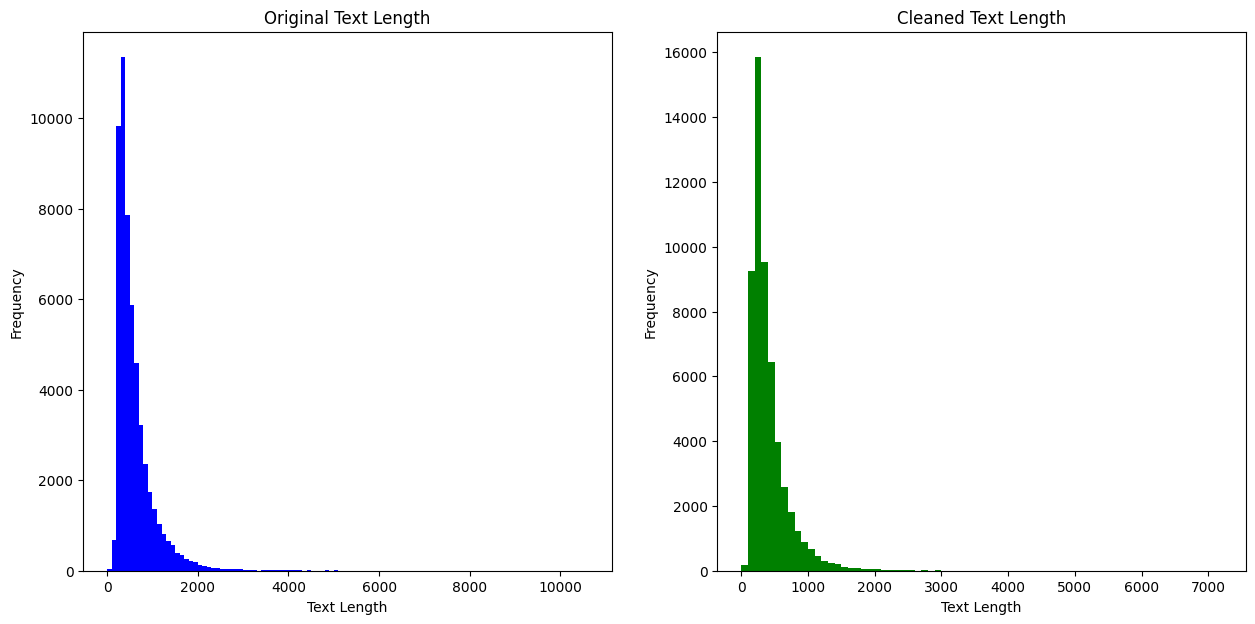

In [36]:
plt.figure(figsize = (15, 7))

#plot Histogram for Original Text length
plt.subplot(1, 2, 1)
plt.hist(train_data['DESCRIPTION_LENGTH'], bins = range(0, max(train_data['DESCRIPTION_LENGTH']) + 100, 100), color = 'blue')
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')


#plot Histogram for Cleaned Text length
plt.subplot(1, 2, 2)
plt.hist(train_data['CLEANED_DESCRIPTION_LENGTH'], bins = range(0, max(train_data['CLEANED_DESCRIPTION_LENGTH']) + 100, 100), color = 'green')
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.show()


In [37]:
desc_length = len(train_data[train_data['DESCRIPTION_LENGTH'] > 2000])
print(f'Number of rows for Description text length above 2000 before cleaning: {desc_length}')

cleaned_desc_length = len(train_data[train_data['CLEANED_DESCRIPTION_LENGTH'] > 2000])
print(f'Number of rows for Description text length above 2000 after cleaning: {cleaned_desc_length}')

Number of rows for Description text length above 2000 before cleaning: 863
Number of rows for Description text length above 2000 after cleaning: 200


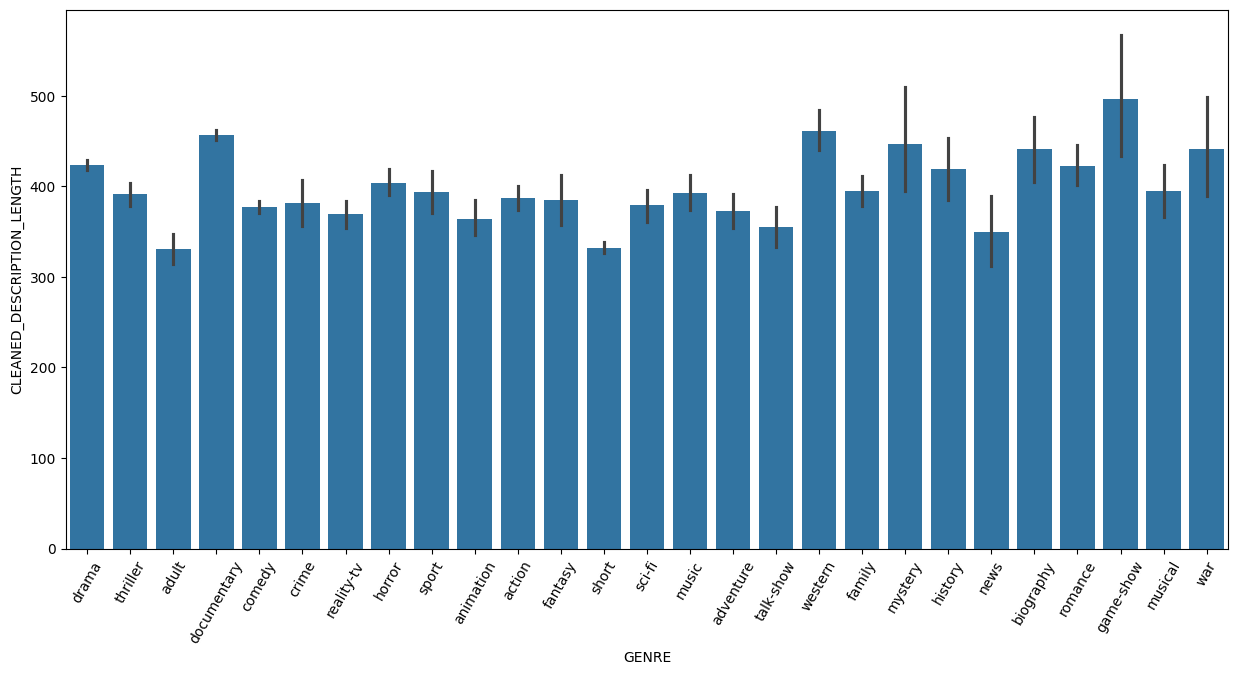

In [38]:
plt.figure(figsize = (15,7))
sns.barplot(x = 'GENRE' ,y = 'CLEANED_DESCRIPTION_LENGTH' ,data = train_data)
plt.xticks(rotation = 60)
plt.show()

#### Text Vectorization using TF-IDF

In [41]:
#Initializing the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

In [42]:
#Fit and transform the training and testing data
X_train = vectorizer.fit_transform(train_data['CLEANED_DESCRIPTION'])
X_test = vectorizer.transform(test_data['CLEANED_DESCRIPTION'])

#### Train-Test split

In [43]:
X = X_train
y = train_data['GENRE']

In [44]:
X_train, X_value, y_train, y_value = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [45]:
#Checking the shapes after the train test split to avoid dimenstionality issues
print("Shapes after the Train Test split")
print(f'X_train : {X_train.shape}')
print(f'X_value : {X_value.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_value : {y_value.shape}')

Shapes after the Train Test split
X_train : (43371, 124210)
X_value : (10843, 124210)
y_train : (43371,)
y_value : (10843,)


#### Naive Bayes Classifier

In [46]:
#Initialize the Multinomial Naive Bayes Classifer
classifier_1 = MultinomialNB()

In [47]:
#Train the model
classifier_1.fit(X_train, y_train)

MultinomialNB()

In [48]:
#Predicting on validation set
y_pred = classifier_1.predict(X_value)

In [49]:
#Evaluation of the model
accuracy = accuracy_score(y_value, y_pred)
print("Accurracy of the model: ", accuracy)

Accurracy of the model:  0.44526422576777647


In [50]:
print(classification_report(y_value, y_pred))

              precision    recall  f1-score   support

      action       0.00      0.00      0.00       263
       adult       0.00      0.00      0.00       112
   adventure       0.00      0.00      0.00       139
   animation       0.00      0.00      0.00       104
   biography       0.00      0.00      0.00        61
      comedy       0.61      0.04      0.07      1443
       crime       0.00      0.00      0.00       107
 documentary       0.54      0.90      0.67      2659
       drama       0.38      0.88      0.53      2697
      family       0.00      0.00      0.00       150
     fantasy       0.00      0.00      0.00        74
   game-show       0.00      0.00      0.00        40
     history       0.00      0.00      0.00        45
      horror       0.00      0.00      0.00       431
       music       0.00      0.00      0.00       144
     musical       0.00      0.00      0.00        50
     mystery       0.00      0.00      0.00        56
        news       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Test Data Prediction

In [51]:
X_test_pred = classifier_1.predict(X_test)

In [52]:
test_data['PREDICTED_GENRE'] = X_test_pred

In [53]:
test_data.head()

,ID,TITLE,DESCRIPTION,CLEANED_DESCRIPTION,PREDICTED_GENRE
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",brane loves life car apartment job especially ...,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...",spain march quico naughty child three belongin...,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...,one year life albin family shepherds north tra...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...",father died hasnt spoken brother years serious...,drama
4,5,Er nu zhai (1955),Before he was known internationally as a marti...,known internationally martial arts superstar b...,drama


In [54]:
test_data.sample(10)

,ID,TITLE,DESCRIPTION,CLEANED_DESCRIPTION,PREDICTED_GENRE
26823,26824,The Journals of Knud Rasmussen (2006),The last great shaman of the Inuit Avva and hi...,last great shaman inuit avva beautiful headstr...,documentary
24334,24335,Commander in Heels (2012),Special takes viewers inside the lives of two ...,special takes viewers inside lives two top fem...,documentary
9546,9547,Boca de Ouro (1990),"When major drug-dealer Boca de Ouro dies, a re...",major drug dealer boca ouro dies reporter inte...,drama
26234,26235,24 sata (2002),A two-part omnibus consisting of b/w comedy ab...,two part omnibus consisting comedy group frien...,drama
32864,32865,Privilege and Obsession (2015),Privilege and Obsession was filmed at Oberlin ...,privilege obsession filmed oberlin college obe...,documentary
10375,10376,Bradman: The Movie (1998),As the Planet TiMaster faces the brink of dest...,planet timaster faces brink destruction brilli...,drama
9599,9600,Una vela para el diablo (1973),Two sisters running a small hotel in Spain kil...,two sisters running small hotel spain kill fem...,drama
38104,38105,Wagon Tracks West (1943),Fleetwing has gone east to become a doctor and...,fleetwing gone east become doctor first patien...,drama
34985,34986,When a City Falls (2011),A documentary following the lives of Cantabria...,documentary following lives cantabrians earthq...,documentary
13056,13057,Unveiled Live Concert DVD (2008),"Experience a live concert as never before, wit...",experience live concert never one hour signatu...,documentary


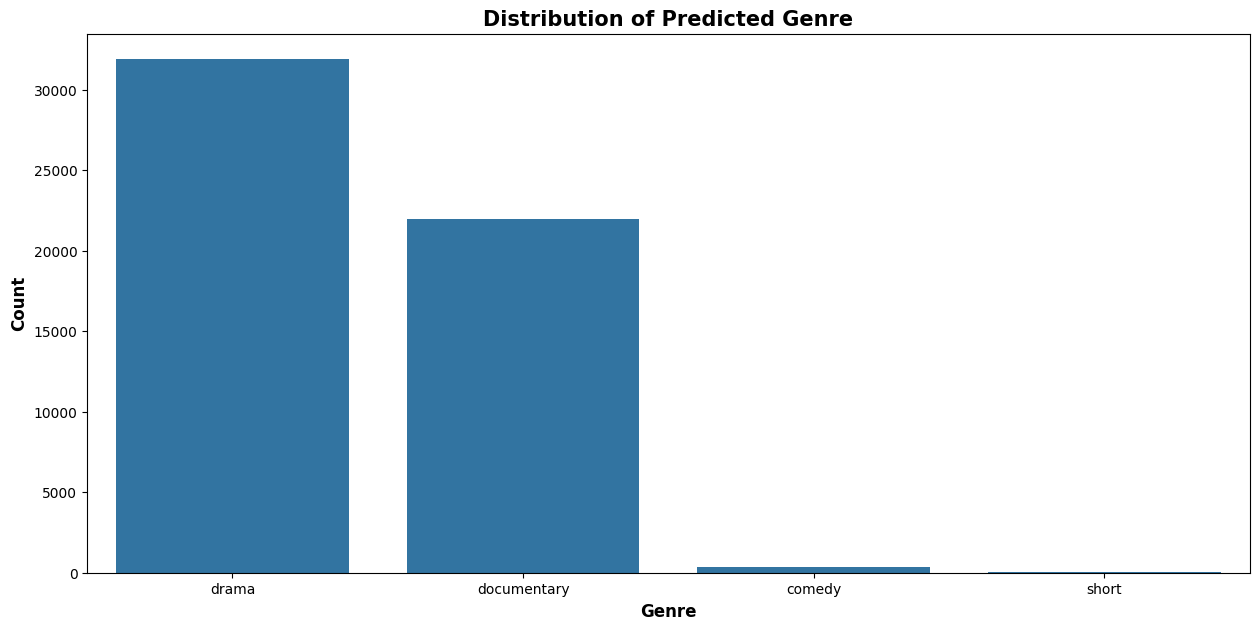

In [55]:
# Visualize the distribution of predicted genres
#Describing the figure size
plt.figure(figsize = (15, 7))

#Creating the countplot
sns.countplot(data = test_data, x = 'PREDICTED_GENRE')

#set title for the plot
plt.title('Distribution of Predicted Genre', fontsize = 15, fontweight = 'bold')
#set label for x axis
plt.xlabel('Genre', fontsize = 12, fontweight = 'bold')
#set label for y axis
plt.ylabel('Count', fontsize = 12, fontweight = 'bold')
plt.show()

In [56]:
#Getting value count of the predicted genre
test_data['PREDICTED_GENRE'].value_counts()

,count
PREDICTED_GENRE,
drama,31889
documentary,21962
comedy,329
short,20


##### Reference

1. https://www.kaggle.com/faroukfadelbrachemi
2. https://www.youtube.com/watch?v=ATK6fm3cYfI